In [3]:
import coffea
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PHYSLITESchema
from coffea.analysis_tools import PackedSelection
import uproot
from matplotlib import pyplot as plt
import numpy as np
import vector
import awkward as ak
from coffea import dataset_tools
import hist
import dask

In [4]:
print("coffea version: ", coffea.__version__)
print("awkward version: ", ak.__version__)
print("dask version: ", dask.__version__)

coffea version:  2024.5.0
awkward version:  2.6.4
dask version:  2024.5.2


In [5]:
# Hgg -> 4l sample
file_path = '/Users/ekourlitis/cernbox/mc20_13TeV.345060.PowhegPythia8EvtGen_NNLOPS_nnlo_30_ggH125_ZZ4l.deriv.DAOD_PHYSLITE.e7735_s3681_r13167_p6026/mc20_13TeV/DAOD_PHYSLITE.38191712._000020.pool.root.1'

In [6]:
def filter_name(name):
    return name in [
        "AnalysisElectronsAuxDyn.pt",
        "AnalysisElectronsAuxDyn.eta",
        "AnalysisElectronsAuxDyn.phi",
        "AnalysisElectronsAuxDyn.m",
        "AnalysisElectronsAuxDyn.DFCommonElectronsLHLoose",
        "AnalysisElectronsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000",
        "AnalysisElectronsAuxDyn.topoetcone20",
        "AnalysisElectronsAuxDyn.charge",
        "AnalysisMuonsAuxDyn.pt",
        "AnalysisMuonsAuxDyn.eta",
        "AnalysisMuonsAuxDyn.phi",
        "AnalysisMuonsAuxDyn.m",
        "AnalysisMuonsAuxDyn.quality",
        "AnalysisMuonsAuxDyn.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000",
        "AnalysisMuonsAuxDyn.topoetcone20",
    ]

events = NanoEventsFactory.from_root(
    {file_path: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    uproot_options=dict(filter_name=filter_name),
).events()

/opt/miniconda3/envs/coffea_latest/lib/python3.11/site-packages/coffea/nanoevents/methods/physlite.py:10: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import base, vector
/opt/miniconda3/envs/coffea_latest/lib/python3.11/site-packages/coffea/util.py:234: UserWarning: Skipping xTrigDecisionAux.xAOD::AuxInfoBase as it is not interpretable by Uproot
  warnings.warn(
/opt/miniconda3/envs/coffea_latest/lib/python3.11/site-packages/coffea/util.py:

# Highly structured jagged data

In [7]:
events.fields

['Electrons', 'Muons']

In [8]:
events.Electrons.compute()

<ElectronArray [[{pt: 6.98e+03, ...}], ..., [{...}]] type='40000 * var * el...'>

# Data selection and feature engineering

In [9]:
def object_selection(events):
    '''
    Select objects based on kinematic and quality criteria
    '''
    
    electrons = events.Electrons
    muons = events.Muons
    
    electron_reqs = (electrons.pt > 20) & \
                    (np.abs(electrons.eta) < 2.47) & \
                    (electrons.DFCommonElectronsLHLoose == 1) & \
                    (electrons.ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000/electrons.pt < 0.15) & \
                    (electrons.topoetcone20/electrons.pt < 0.2)
                    
    # add quality requirements here
    muon_reqs = (muons.pt > 20) & \
                (np.abs(muons.eta) < 2.7) & \
                (muons.quality == 2) & \
                (muons.ptvarcone30_Nonprompt_All_MaxWeightTTVA_pt1000/muons.pt < 0.15) & \
                (muons.topoetcone20/muons.pt < 0.3)
    
    # only keep objects that pass our requirements
    electrons = electrons[electron_reqs]
    muons = muons[muon_reqs]
    
    return electrons, muons

def region_selection(electrons, muons):
    '''
    Select events based on object multiplicity
    '''
    
    selections = PackedSelection(dtype='uint64')
    # basic selection criteria
    selections.add("exactly_4e", ak.num(electrons) == 4)
    selections.add("total_e_charge_zero", ak.sum(electrons.charge, axis=1) == 0)
    selections.add("exactly_0m", ak.num(muons) == 0)
    # selection criteria combination
    selections.add("4e0m", selections.all("exactly_4e", "total_e_charge_zero", "exactly_0m"))
    
    return selections.all("4e0m")

def calculate_inv_mass(electrons):
    '''
    Construct invariant mass observable
    '''
    
    # reconstruct Higgs as 4e system
    candidates = ak.combinations(electrons, 4)
    e1, e2, e3, e4 = ak.unzip(candidates)
    candidates["p4"] = e1 + e2 + e3 + e4
    higgs_mass = candidates["p4"].mass
    observable = ak.flatten(higgs_mass/1000)
    
    return observable

In [10]:
# select objects and events
el, mu = object_selection(events)
selection_4e0m = region_selection(el, mu)

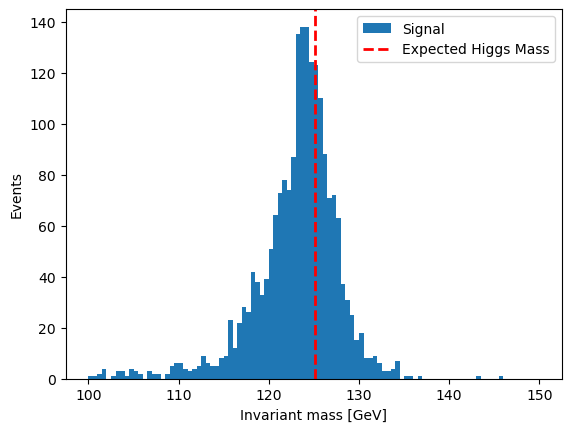

In [11]:
plt.hist(calculate_inv_mass(el[selection_4e0m]).compute(), bins=100, range=(100, 150), label='Signal')
plt.axvline(125.11, color='r', linestyle='dashed', linewidth=2, label='Expected Higgs Mass')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Events')
plt.legend()
plt.show()

# Scale out processing over multiple files

In [12]:
fileset = {"zz"     : {'files': {'/Users/ekourlitis/cernbox/mc20_13TeV.700600.Sh_2212_llll.deriv.DAOD_PHYSLITE.e8433_s3681_r13167_p6026/mc20_13TeV/DAOD_PHYSLITE.37110926._000047.pool.root.1' : "CollectionTree"},
                      'metadata': {'process': 'zz'}},
           "higgs"  : {'files': {'/Users/ekourlitis/cernbox/mc20_13TeV.345060.PowhegPythia8EvtGen_NNLOPS_nnlo_30_ggH125_ZZ4l.deriv.DAOD_PHYSLITE.e7735_s3681_r13167_p6026/mc20_13TeV/DAOD_PHYSLITE.38191712._000020.pool.root.1' : "CollectionTree"}, 
                      'metadata': {'process': 'higgs'}}}

# pre-process
samples, _ = dataset_tools.preprocess(fileset)

In [13]:
# create histogram with observables
def create_histogram(events):
    hist_4e0m = (
        hist.dask.Hist.new.Reg(100, 100, 150, name='m_eeee', label=r"$m_{eeee}$ [GeV]")
        .StrCat([], name='process', label='Process', growth=True)
        .Weight()
    )

    process = events.metadata['process']

    # normalization for MC
    # x_sec = events.metadata["xsec"]
    # nevts_total = events.metadata["nevts"]
    # lumi = 3378 # /pb
    # if process != "data":
    #     xsec_weight = x_sec * lumi / nevts_total
    # else:
    #     xsec_weight = 1

    el, mu = object_selection(events)

    # region selection
    selection_4e0m = region_selection(el, mu)

    # observable
    inv_mass = calculate_inv_mass(el[selection_4e0m])
    hist_4e0m.fill(inv_mass, process=process)

    return {"4e0m": hist_4e0m}

In [14]:
# create the task graph
tasks = dataset_tools.apply_to_fileset(create_histogram, 
                                       samples, 
                                       schemaclass=PHYSLITESchema, 
                                       uproot_options=dict(filter_name=filter_name))

In [15]:
%%time
# execute
(out, ) = dask.compute(tasks)

CPU times: user 1.66 s, sys: 110 ms, total: 1.77 s
Wall time: 1.77 s


In [16]:
full_histogram = sum([v["4e0m"] for v in out.values()])

Text(0, 0.5, 'Events')

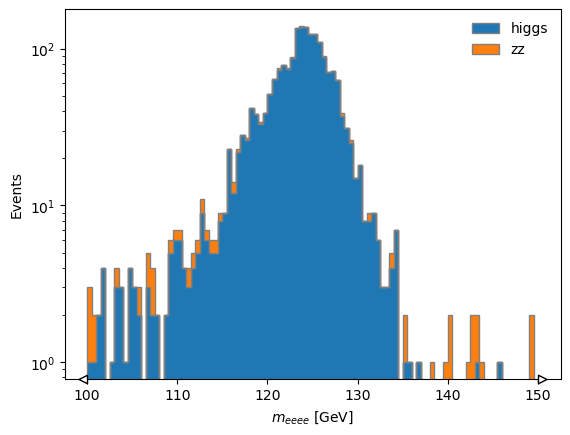

In [18]:
artists = full_histogram.stack("process")[::-1].plot(
    stack=True, histtype="fill", linewidth=1, edgecolor="grey", 
)

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)
ax.set_yscale("log")
ax.set_ylabel("Events")